# Synthetic basaltic glasses

This notebook contains code for:

- Compiling major element analyses (all elements except nitrogen)
- Inspecting and fitting WD scans

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, ".")
sys.path.insert(1, "..")

In [24]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

np.random.seed(42)

In [25]:
# For reference: how to rename folders

# from src.readfiles import rename_folders_as_comments

# for f in os.listdir("../data/raw/basaltic_glasses_StA/raw_quant_20211222/original/"):
#     print(f)
                    
#     rename_folders_as_comments(
#         Path(f"../data/raw/basaltic_glasses_StA/raw_quant_20211222/original/{f}"), 
#         "../data/raw/basaltic_glasses_StA/raw_quant_20211222/renamed")

In [26]:
import pyrolite.geochem

# Major/trace elements other than N

In [27]:
def get_major_elements_from_txt(path):

    majors_raw = pd.read_csv(
        path,
        header=1,
        index_col=False
        )
    
    majors_raw = majors_raw.loc[majors_raw["Comment"].notna(), :]

    mass_pct_cols = [col for col in majors_raw.columns if "(Mass%)" in col]
    majors = majors_raw.loc[:, ["Comment"] + mass_pct_cols].rename(columns={col: col.replace("(Mass%)", "") for col in mass_pct_cols})
    detlims = majors_raw.loc[:, ["Comment"] + [col for col in majors_raw.columns if "(D.L.)" in col]]
    return majors, detlims

majors = {}
detlims = {}
for s in ["Edi06", "Edi09", "D2872"]:

    majors[s], detlims[s] = get_major_elements_from_txt(
        f"../data/raw/basaltic_glasses_StA/majors_20211110/{s.lower()}_all.txt"
    )

# for D2983 I didn't get an "_all.txt" file so I need to get the data differently

majors["D2893"] = pd.read_csv(
    "../data/raw/basaltic_glasses_StA/majors_20211110/D2893_2_oxide.csv",
    header=1,
    index_col=False
)
majors["D2893"].columns = [c.strip() for c in majors["D2893"].columns]
majors["D2893"] = majors["D2893"].loc[majors["D2893"]["Comment"].notna(), :]

detlims["D2893"] = pd.read_csv(
    "../data/raw/basaltic_glasses_StA/majors_20211110/D2893_2_detlim.txt",
    header=1,
    index_col=False
)
detlims["D2893"].columns = [c.strip() for c in detlims["D2893"].columns]
detlims["D2893"] = detlims["D2893"].loc[detlims["D2893"]["Comment"].notna(), :]


c:\Users\Eleanor\miniconda3\envs\n_epma_analysis\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [28]:
majors["D2893"]

,No.,SiO2,Al2O3,Cl,P2O5,Fe2O3,MnO,Cr2O3,K2O,CaO,Ru2O3,Na2O,MgO,Total,Comment
0,3,47.31,14.82,1.01,0.1869,8.23,0.3209,0.0779,0.1966,14.15,0.0000,1.73,8.64,96.6724,D2983_qnt_v2_2
1,4,47.35,14.91,1.02,0.1839,8.22,0.3310,0.0649,0.1929,14.20,0.0205,1.74,8.68,96.9133,D2983_qnt_v2_3
2,5,47.47,14.89,1.02,0.2011,8.26,0.3132,0.0637,0.2041,14.25,0.0171,1.65,8.67,97.0093,D2983_qnt_v2_4
3,6,47.35,14.86,1.01,0.1920,8.21,0.2987,0.0586,0.1882,14.16,0.0222,1.68,8.63,96.6598,D2983_qnt_v2_5


In [29]:
majors["D2872"]

,Comment,SiO2,Al2O3,Cl,P2O5,Fe2O3,MnO,Cr2O3,K2O,CaO,Ru2O3,Na2O,MgO,Total
0,D2872_qnt_v2_1,48.85,15.40,4.40,0.1624,0.1985,0.2295,0.0349,0.2062,14.61,0.0,1.75,8.81,94.6515
1,D2872_qnt_v2_2,48.76,15.27,4.45,0.2025,0.1682,0.2334,0.0403,0.2061,14.72,0.0,1.74,8.82,94.6105
2,D2872_qnt_v2_3,48.77,15.37,4.42,0.1897,0.2264,0.2468,0.0455,0.2161,14.61,0.0,1.72,8.82,94.6345
3,D2872_qnt_v2_4,48.92,15.43,4.32,0.1918,0.1704,0.2401,0.0223,0.2006,14.71,0.0,1.70,8.76,94.6652
4,D2872_qnt_v2_5,49.03,15.38,4.38,0.1886,0.1995,0.2321,0.0334,0.2073,14.55,0.0,1.71,8.76,94.6709


In [30]:
majors["Edi06"]

,Comment,SiO2,Al2O3,Cl,P2O5,Fe2O3,MnO,Cr2O3,K2O,CaO,Ru2O3,Na2O,MgO,Total
0,Edi06_qnt_v3_1,49.58,14.64,0.0023,0.1973,8.79,0.3522,0.0409,0.2045,14.90,0.0333,1.81,9.31,99.8605
1,Edi06_qnt_v3_2,49.45,14.72,0.0070,0.1885,8.69,0.3381,0.0468,0.2138,14.89,0.0000,1.76,9.29,99.5942
2,Edi06_qnt_v3_3,49.58,14.51,0.0003,0.2015,8.63,0.3357,0.0626,0.2058,14.87,0.0000,1.82,9.33,99.5459


In [31]:
majors["Edi09"]

,Comment,SiO2,Al2O3,Cl,P2O5,Fe2O3,MnO,Cr2O3,K2O,CaO,Ru2O3,Na2O,MgO,Total
0,Edi09_qnt_v3_1,47.26,14.91,0.0064,0.1974,8.51,0.3112,0.0978,0.1780,14.16,0.0000,1.71,8.62,95.9608
1,Edi09_qnt_v3_2,47.49,14.97,0.0060,0.1971,8.28,0.3030,0.0832,0.1941,14.09,0.0000,1.66,8.57,95.8434
2,Edi09_qnt_v3_3,47.51,14.80,0.0040,0.1832,8.41,0.3275,0.0865,0.1930,14.18,0.0000,1.72,8.60,96.0142
3,Edi09_qnt_v3_4,47.43,14.85,0.0070,0.1945,8.21,0.3070,0.0883,0.1983,14.17,0.0575,1.75,8.60,95.8626
4,Edi09_qnt_v3_5,47.39,14.98,0.0121,0.1954,8.36,0.3355,0.0917,0.1902,14.19,0.0000,1.69,8.60,96.0349


In [32]:
majors_element = {}

for k, df in majors.items():

    majors_element[k] = df[
        ['SiO2', 'Al2O3', 'Cl', 'P2O5', 'Fe2O3', 'MnO', 'Cr2O3', 'K2O', 'CaO', 'Ru2O3', 'Na2O', 'MgO']
        ].pyrochem.convert_chemistry(
        to=['Si', 'Al', 'Cl', 'P', 'Fe', 'Mn', 'Cr', 'K', 'Ca', 'Ru', 'Na', 'Mg']
    ).fillna(0)

    majors_element[k]["O"] = df["Total"] - (majors_element[k].sum(axis=1))

    majors_element[k]["Total"] = majors_element[k].sum(axis=1)


In [33]:
majors_element

{'Edi06':           Si        Al      Cl         P        Fe        Mn        Cr         K         Ca       Ru        Na        Mg          O    Total
 0  23.175423  7.748230  0.0023  0.086106  6.147950  0.272764  0.027984  0.169765  10.648892  0.02691  1.342762  5.614264  44.597149  99.8605
 1  23.114657  7.790570  0.0070  0.082265  6.078008  0.261844  0.032021  0.177486  10.641746  0.00000  1.305669  5.602203  44.500731  99.5942
 2  23.175423  7.679428  0.0003  0.087939  6.036042  0.259985  0.042831  0.170844  10.627452  0.00000  1.350181  5.626325  44.489150  99.5459,
 'Edi09':           Si        Al      Cl         P        Fe        Mn        Cr         K         Ca        Ru        Na        Mg          O    Total
 0  22.090974  7.891128  0.0064  0.086149  5.952111  0.241011  0.066915  0.147766  10.120021  0.000000  1.268576  5.198169  42.891578  95.9608
 1  22.198484  7.922883  0.0060  0.086019  5.791243  0.234661  0.056926  0.161132  10.069993  0.000000  1.231483  5.168018  42.

In [34]:
majors_summary = {}

for k, df in majors_element.items():
    majors_summary[k] = pd.concat([df.T.mean(axis=1), df.T.std(axis=1)], axis=1)
    n = len(df.index)
    majors_summary[k].columns = ["wt% mean", f"stdev (n={n})"]

majors_summary_combined = pd.concat(majors_summary, axis=1)

In [35]:
majors_summary_combined.round(3)

Edi06                Edi09                D2872                D2893            
      wt% mean stdev (n=3) wt% mean stdev (n=5) wt% mean stdev (n=5) wt% mean stdev (n=4)
Si      23.155       0.035   22.164       0.046   22.842       0.053   22.142       0.032
Al       7.739       0.056    7.887       0.041    8.135       0.032    7.870       0.021
Cl       0.003       0.003    0.007       0.003    4.394       0.049    1.015       0.006
P        0.085       0.003    0.084       0.003    0.082       0.006    0.083       0.003
Fe       6.087       0.057    5.843       0.081    0.135       0.017    5.756       0.015
Mn       0.265       0.007    0.245       0.011    0.183       0.005    0.245       0.011
Cr       0.034       0.008    0.061       0.004    0.024       0.006    0.045       0.006
K        0.173       0.004    0.158       0.006    0.172       0.005    0.162       0.006
Ca      10.639       0.011   10.119       0.028   10.463       0.052   10.141       0.032
Ru       0.009       0.016    0.009       0.021    0.000       0.000    0.012       0.008
Na       1.333       0.024    1.266       0.025    1.279       0.015    1.261       0.031
Mg       5.614       0.012    5.185       0.011    5.303       0.019    5.219       0.014
O       44.529       0.059   42.914       0.030   41.636       0.050   42.860       0.072
Total   99.667       0.169   95.943       0.087   94.647       0.025   96.814       0.175

In [36]:
majors_summary_combined.round(3).to_csv("../data/processed/basaltic_glasses/basaltic_glasses_majors_summary.csv")
majors_summary_combined.round(3)

Edi06                Edi09                D2872                D2893            
      wt% mean stdev (n=3) wt% mean stdev (n=5) wt% mean stdev (n=5) wt% mean stdev (n=4)
Si      23.155       0.035   22.164       0.046   22.842       0.053   22.142       0.032
Al       7.739       0.056    7.887       0.041    8.135       0.032    7.870       0.021
Cl       0.003       0.003    0.007       0.003    4.394       0.049    1.015       0.006
P        0.085       0.003    0.084       0.003    0.082       0.006    0.083       0.003
Fe       6.087       0.057    5.843       0.081    0.135       0.017    5.756       0.015
Mn       0.265       0.007    0.245       0.011    0.183       0.005    0.245       0.011
Cr       0.034       0.008    0.061       0.004    0.024       0.006    0.045       0.006
K        0.173       0.004    0.158       0.006    0.172       0.005    0.162       0.006
Ca      10.639       0.011   10.119       0.028   10.463       0.052   10.141       0.032
Ru       0.009       0.016    0.009       0.021    0.000       0.000    0.012       0.008
Na       1.333       0.024    1.266       0.025    1.279       0.015    1.261       0.031
Mg       5.614       0.012    5.185       0.011    5.303       0.019    5.219       0.014
O       44.529       0.059   42.914       0.030   41.636       0.050   42.860       0.072
Total   99.667       0.169   95.943       0.087   94.647       0.025   96.814       0.175

In [37]:
detlims["Edi09"]

,Comment,Si(D.L.),Al(D.L.),Cl(D.L.),P(D.L.),Fe(D.L.),Mn(D.L.),Cr(D.L.),K(D.L.),Ca(D.L.),Ru(D.L.),Na(D.L.),Mg(D.L.)
0,Edi09_qnt_v3_1,103.0,59.0,42.0,56.0,202.0,81.0,77.0,38.0,57.0,169.0,71.0,32.0
1,Edi09_qnt_v3_2,101.0,60.0,41.0,56.0,204.0,82.0,76.0,36.0,55.0,158.0,65.0,32.0
2,Edi09_qnt_v3_3,104.0,59.0,45.0,56.0,201.0,80.0,74.0,37.0,55.0,162.0,72.0,32.0
3,Edi09_qnt_v3_4,104.0,60.0,42.0,54.0,199.0,80.0,77.0,36.0,55.0,150.0,67.0,32.0
4,Edi09_qnt_v3_5,101.0,59.0,43.0,52.0,192.0,79.0,74.0,37.0,55.0,176.0,70.0,31.0


# Wavelength scans

I recorded scans at different conditions on different days. Check whether they are comparable and choose which to use for fitting

In [38]:
samplenames = ["D2872", "D2893", "Edi09", "Edi06"]
metadata_list = {}
data_list = {}

for s in samplenames:
    print(f"---------------- {s} ----------------")

    folderpath_list = [
        f"../data/raw/basaltic_glasses_StA/wd_scans_20211008/{s}",
        f"../data/raw/basaltic_glasses_StA/wd_scans_20211125/{s}",
        f"../data/raw/basaltic_glasses_StA/wd_scans_20211222/{s}"
    ]

    metadata_list[s] = []
    data_list[s] = []

    for i, f in enumerate(folderpath_list):
        # Read in the data
        for d in ["data001", "data002"]:
            try:             
                comments, data, metadata = readfiles.import_jeol_wdscans(
                    subfolder=f,
                    scan_filename=f'{d}_mm.csv',
                    cnd_filename=f'{d}.cnd',
                    comment_line_num=80,
                    crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
                    sep=',',
                    return_metadata=True
                )

                metadata_list[s].append(metadata)
                data_list[s].append(data)
            except FileNotFoundError:
                 print(f"No file found for {d}")


---------------- D2872 ----------------
No file found for data002
No file found for data002
---------------- D2893 ----------------
No file found for data002
No file found for data002
---------------- Edi09 ----------------
No file found for data002
No file found for data002
---------------- Edi06 ----------------
No file found for data001
No file found for data002
No file found for data001
No file found for data002
No file found for data002


--------------------D2872-------------------


,0,1,2
folder,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...
comment,D2872-scan,D2872_longscan_4,D2872
current_nA,50.26,50.55,101.0
dwell_time_s,0.3,2.0,1.0
accumulations,1,1,1
num_points,3001,1201,301
total_time_mins,15,40,5
crystal,LDE1L,LDE1L,LDE1L
step_size_um,20.0,50.0,200.0


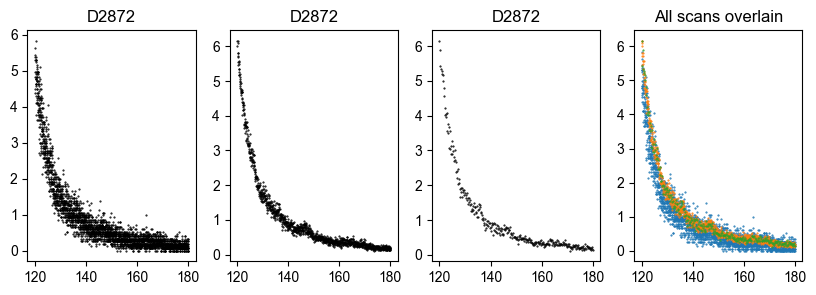

--------------------D2893-------------------


,0,1,2
folder,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...
comment,D2893-scan,D2893_bgcan,D2893
current_nA,50.33,49.83,101.0
dwell_time_s,0.3,2.0,1.0
accumulations,1,1,1
num_points,3001,601,301
total_time_mins,15,20,5
crystal,LDE1L,LDE1L,LDE1L
step_size_um,20.0,100.0,200.0


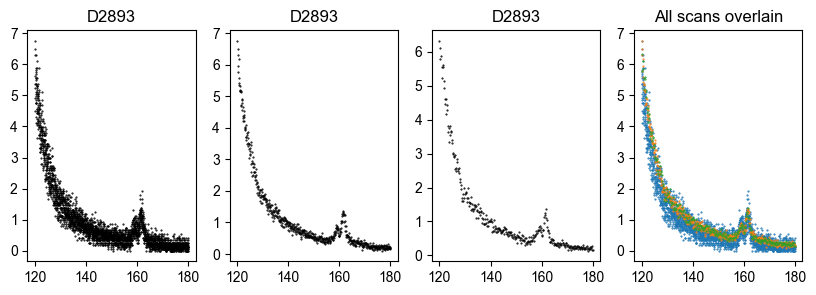

--------------------Edi09-------------------


,0,1,2
folder,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...,..\data\raw\basaltic_glasses_StA\wd_scans_2021...
comment,sample-1,Edi09_bgcan,Edi09
current_nA,50.11,50.54,101.0
dwell_time_s,0.6,2.0,1.0
accumulations,1,1,1
num_points,3001,601,301
total_time_mins,30,20,5
crystal,LDE1L,LDE1L,LDE1L
step_size_um,20.0,100.0,200.0


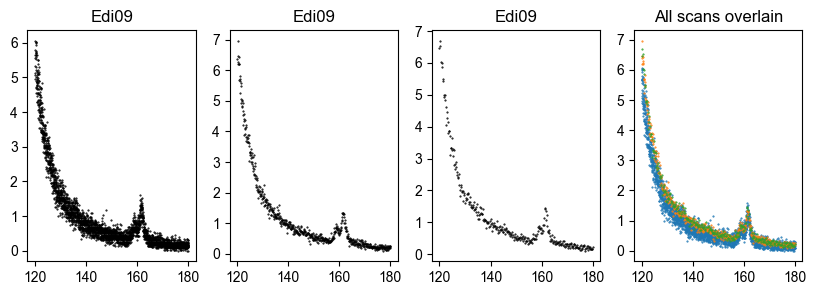

--------------------Edi06-------------------


,0
folder,..\data\raw\basaltic_glasses_StA\wd_scans_2021...
comment,Edi06
current_nA,101.2
dwell_time_s,1.0
accumulations,1
num_points,601
total_time_mins,10
crystal,LDE1L
step_size_um,100.0


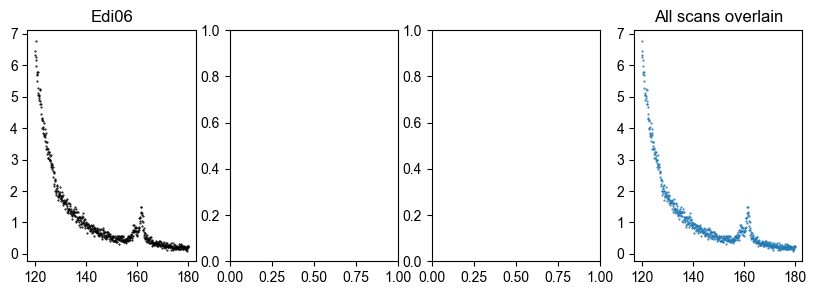

In [39]:
lde1l_scans = {}
lde1_scans = {}

for s in samplenames:
    print(f"--------------------{s}-------------------")
    lde1l_scans[s] = {"metadata": [], "data": []}
    lde1_scans[s] = {"metadata": [], "data": []}

    for i in range(len(data_list[s])):
        if metadata_list[s][i].crystal == "LDE1L":
            lde1l_scans[s]["metadata"].append(metadata_list[s][i])
            lde1l_scans[s]["data"].append(data_list[s][i])

        if metadata_list[s][i].crystal == "LDE1":
            lde1_scans[s]["metadata"].append(metadata_list[s][i])
            lde1_scans[s]["data"].append(data_list[s][i])    


    fig, ax = plt.subplots(ncols=4, figsize=(10, 3))

    for i in range(len(lde1l_scans[s]["data"])):
            data = lde1l_scans[s]["data"][i]

            ax[i].plot(data.L, data.cps_per_nA, ".k", markersize=1)
            ax[i].set_title(s)

            ax[3].plot(data.L, data.cps_per_nA, ".", markersize=1, label=i)
            ax[3].set_title("All scans overlain")

    display(pd.DataFrame(lde1l_scans[s]["metadata"]).T)
    plt.show()

For each of these, we can just fit the middle scan - the highest-resolution one
Except for Edi06 for which there is only a single scan

Question, if we overlay Edi06 and The other glasses all at 100 nA ... do they look right?

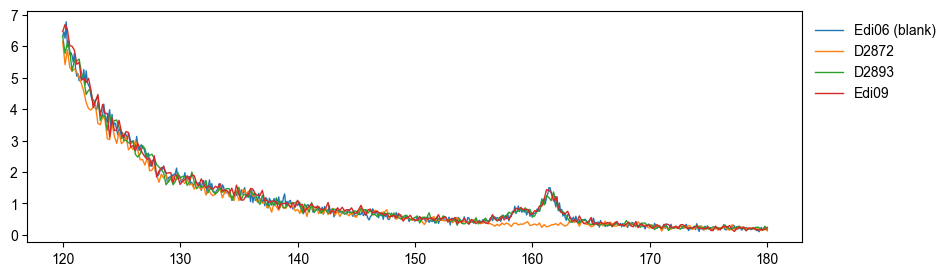

In [40]:
edi06_lde1l_100nA = lde1l_scans["Edi06"]["data"][0]
d2872_lde1l_100nA = lde1l_scans["D2872"]["data"][2]
d2893_lde1l_100nA = lde1l_scans["D2893"]["data"][2]
edi09_lde1l_100nA = lde1l_scans["Edi09"]["data"][2]

fig, ax = plt.subplots(ncols=1, figsize=(10, 3))
ax.plot(edi06_lde1l_100nA.L, edi06_lde1l_100nA.cps_per_nA, label="Edi06 (blank)")
ax.plot(d2872_lde1l_100nA.L, d2872_lde1l_100nA.cps_per_nA, label="D2872")
ax.plot(d2893_lde1l_100nA.L, d2893_lde1l_100nA.cps_per_nA, label="D2893")
ax.plot(edi09_lde1l_100nA.L, edi09_lde1l_100nA.cps_per_nA, label="Edi09")
plt.legend()


Yes, they all look very similar, indistinguishable at the resolution of these scans.


# Fit the wavelength scans
## D2872

LDE1L
Saved figure showing fit to D2872 in folder "..\data\interim\basaltic_glasses\fits"
Saved fit parameters for D2872


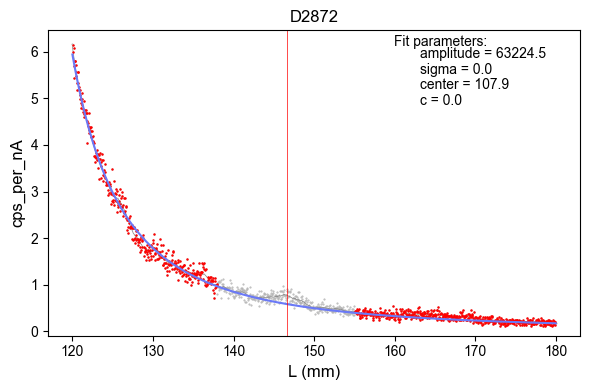

In [41]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,138], [155, 180]]
sample = "D2872"

comments, data, metadata = readfiles.import_jeol_wdscans(
    subfolder="../data/raw/basaltic_glasses_StA/wd_scans_20211125/D2872",
    scan_filename='data001_mm.csv',
    cnd_filename='data001.cnd',
    comment_line_num=80,
    crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
    sep=',',
    return_metadata=True
)
print(metadata.crystal)
trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, [146.6], save_to=Path("../data/interim/basaltic_glasses/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/basaltic_glasses/fits/"))

## D2983

LDE1L
Saved figure showing fit to D2893 in folder "..\data\interim\basaltic_glasses\fits"
Saved fit parameters for D2893


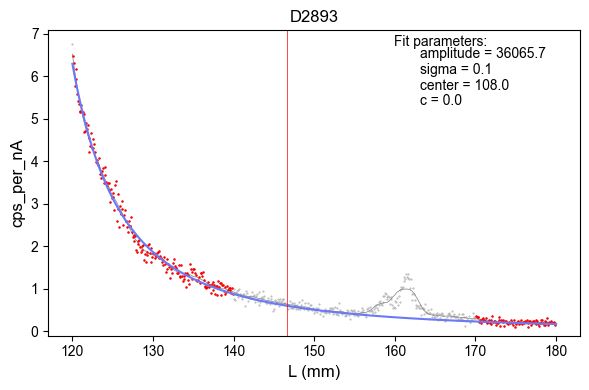

In [42]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,140], [170, 180]]
sample = "D2893"

comments, data, metadata = readfiles.import_jeol_wdscans(
    subfolder="../data/raw/basaltic_glasses_StA/wd_scans_20211125/D2893",
    scan_filename='data001_mm.csv',
    cnd_filename='data001.cnd',
    comment_line_num=80,
    crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
    sep=',',
    return_metadata=True
)

print(metadata.crystal)
trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, [146.6], save_to=Path("../data/interim/basaltic_glasses/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/basaltic_glasses/fits/"))

## Edi09

LDE1L
Saved figure showing fit to Edi09 in folder "..\data\interim\basaltic_glasses\fits"
Saved fit parameters for Edi09


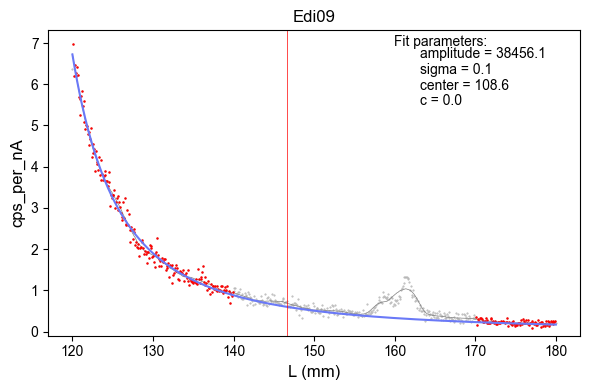

In [43]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,140], [170, 180]]
sample = "Edi09"

comments, data, metadata = readfiles.import_jeol_wdscans(
    subfolder="../data/raw/basaltic_glasses_StA/wd_scans_20211125/Edi09",
    scan_filename='data001_mm.csv',
    cnd_filename='data001.cnd',
    comment_line_num=80,
    crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
    sep=',',
    return_metadata=True
)

print(metadata.crystal)
trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, [146.6], save_to=Path("../data/interim/basaltic_glasses/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/basaltic_glasses/fits/"))

## Edi06

LDE1L
Saved figure showing fit to Edi06 in folder "..\data\interim\basaltic_glasses\fits"
Saved fit parameters for Edi06


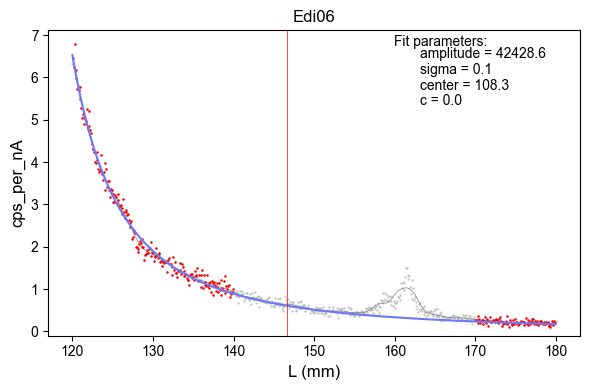

In [44]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,140], [170, 180]]
sample = "Edi06"

comments, data, metadata = readfiles.import_jeol_wdscans(
    subfolder="../data/raw/basaltic_glasses_StA/wd_scans_20211222/Edi06",
    scan_filename='data001_mm.csv',
    cnd_filename='data001.cnd',
    comment_line_num=80,
    crystal_line_name="$XM_WDS_CRYSTAL_NAME%0",
    sep=',',
    return_metadata=True
)

print(metadata.crystal)
trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, [146.6], save_to=Path("../data/interim/basaltic_glasses/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/basaltic_glasses/fits/"))